# Generative Adversarial Networks (GAN)


In [ ]:
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

from skimage.io import imread

import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Loading data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

We scale the data so that the image pixels are centred around 0. This improves training because the network doesn't deal with big values all that well. This is done by dividing the values by 255, multiplying the values by two, and finally subtracting 1.

Let's look at some examples in order to better understand the operations here:

- Pixel value $p = 0$ (lowest value):
  $$(\frac{0}{255} * 2) - 1\ = \ (0 * 2) - 1 \ = \ -1$$

- Pixel value $p = 255$ (highest value):
  $$(\frac{255}{255} * 2) - 1\ = \ (1 * 2) - 1 \ = \ 1$$

- Pixel value $p = 127$ (around middle):
  $$(\frac{127}{255} * 2) - 1\ \approx \ (\frac{1}{2} * 2) - 1 \ = \ 0$$

We multiply by two to ensure the data fits in the range $[-1, 1]$. If we just divide by the maximum value $255$ and don't multiply by two, the interval for the data is $[0, 1]$. If we don't subtract $1$, the interval will be $[0, 2]$.


In [ ]:
# Mapping inputs to (-1, +1) to improve training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 - 1

Since we're processing the images without convolution, we need to flatten the tabular data.


In [ ]:
# Flattening data
N, H, W = x_train.shape
D = H * W

x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

The dimensionality of the latent space determines the range and diversity of possible outputs the generator can produce. The generator learns to map these latent vectors to meaningful samples in the target domain. Similar latent vectors correspond to similar outputs, making the latent space structured and continuous.

Higher-dimensional latent spaces can capture more complex and detailed features, producing more diverse outputs. Lower-dimensional latent spaces may cause a bottleneck, limiting the generator's ability to create diverse outputs and potentially leading to mode collapse (generator producing only a few types of outputs).


In [ ]:
# Dimensionality of the latent space
latent_dim = 100

We use $tanh$ as an activation function for the head of the model, because of the data range being $[-1, 1]$


In [ ]:
# Building generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)  # Because the data is in range (-1, +1)

    model = Model(i, x)
    return model

In [ ]:
# Building discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(i, x)
    return model

In [ ]:
# Compile both models in preparation for training

# Build and compile discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'],
)

# Build and compile the generator
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real
fake_pred = discriminator(img)

# Create combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
)

In [ ]:
# Train the GAN

# Config
batch_size = 32
epochs = 30000
sample_period = 200  # Every 'sample_period' steps generate and save some data

# Create batch labels to use them when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
discriminator_losses = []
generator_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [ ]:
# A function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    # Rescaling images 0 -1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i, j].axis('off')
            idx += 1
    fig.savefig(f'gan_images/{epoch}.png')
    plt.close()

In [ ]:
# Main training loop
for epoch in range(epochs):
    # Selecting a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    # Generating fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    # Generating new noise
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)

    # Saving the losses
    discriminator_losses.append(d_loss)
    generator_losses.append(g_loss)

    if epoch % 100 == 0:
        print(
            f'epoch: {epoch + 1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}'
        )

    if epoch % sample_period == 0:
        sample_images(epoch)

In [ ]:
plt.plot(generator_losses, label='g_losses')
plt.plot(discriminator_losses, label='discriminator_losses')
plt.legend()
plt.show()

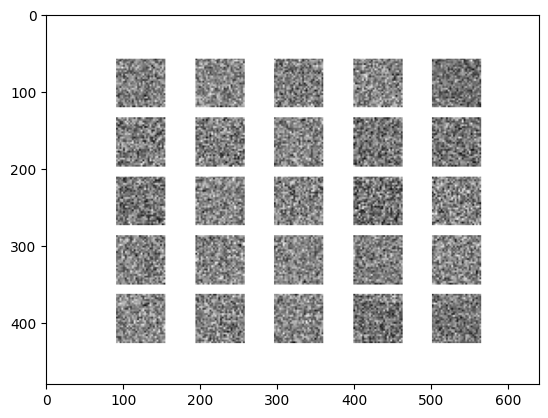

In [ ]:
# Showing first generated images
a = imread('gan_images/0.png')
plt.imshow(a)

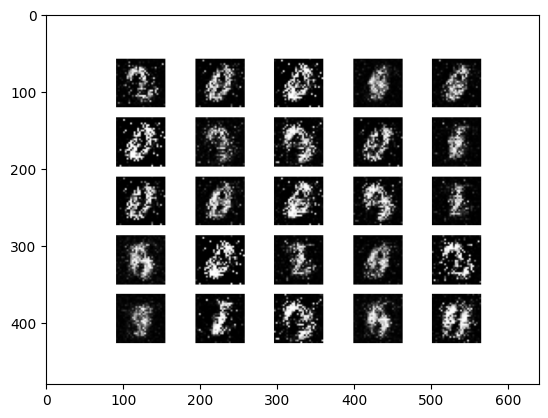

In [ ]:
a = imread('gan_images/1000.png')
plt.imshow(a)

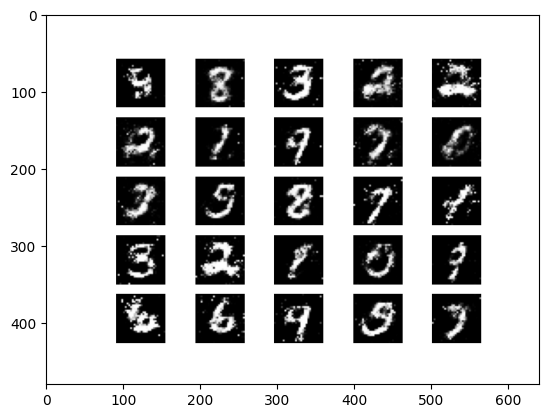

In [ ]:
a = imread('gan_images/5000.png')
plt.imshow(a)

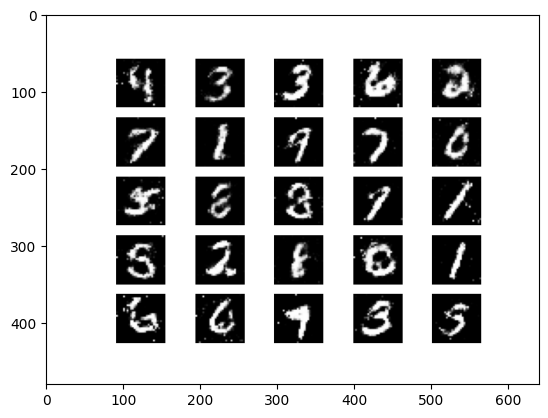

In [ ]:
a = imread('gan_images/10000.png')
plt.imshow(a)

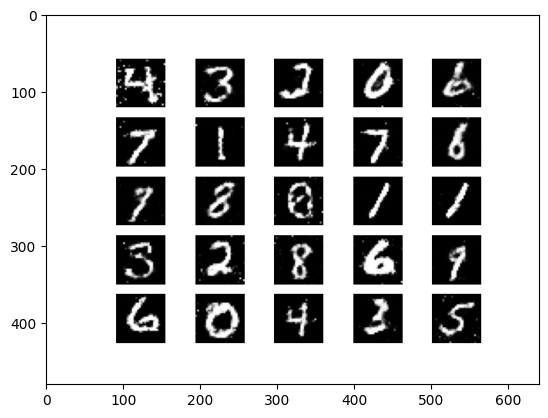

In [ ]:
a = imread('gan_images/20000.png')
plt.imshow(a)

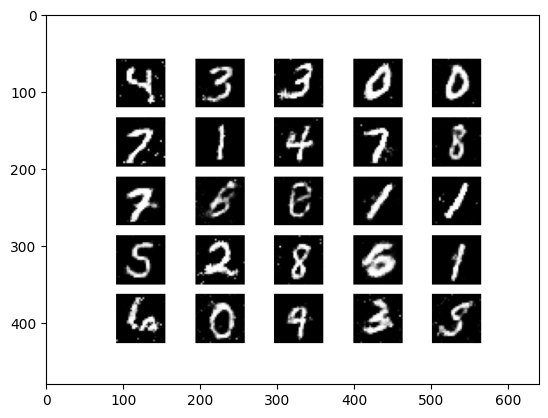

In [ ]:
a = imread('gan_images/29800.png')
plt.imshow(a)